In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
train_dir = '../input/garbage-classification/Garbage classification/Garbage classification'
files = os.listdir(train_dir)
print(files)

['cardboard', 'plastic', 'paper', 'glass', 'metal', 'trash']


In [5]:
class GarbageDataset(Dataset):
    def __init__(self, filelist,directory,transform = None):
        self.filelist = filelist
        self.directory = directory
        self.transform = transform
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.directory, self.filelist[idx]))
        img = self.transform(img)
        
        if 'cardboard' in self.filelist[0]:
            self.label = 0
        elif 'glass' in self.filelist[0]:
            self.label = 1
        elif 'metal' in self.filelist[0]:
            self.label = 2
        elif 'paper' in self.filelist[0]:
            self.label = 3
        elif 'plastic' in self.filelist[0]:
            self.label = 4
        elif 'trash' in self.filelist[0]:
            self.label = 5
        
        img = img.numpy()
        return img.astype('float32'), self.label

In [6]:
classes = ['cardboard','glass','metal','paper','plastic','trash']
working_ds = None
for c in classes:
    directory = os.path.join(train_dir,c)
    filelist = os.listdir(directory)
    new = GarbageDataset(filelist,directory,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))

2527


In [7]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [8]:
train_ds,val_ds = train_val_split(working_ds)


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

In [10]:
for i,l in train_loader:
    c = 0
    c= c+1
    print(l)
    if c == 1:
        break

tensor([1, 0, 3, 1, 2, 2, 0, 1, 4, 3, 4, 4, 0, 3, 4, 0, 2, 1, 4, 2, 3, 1, 4, 4,
        3, 2, 2, 2, 1, 1, 3, 2])


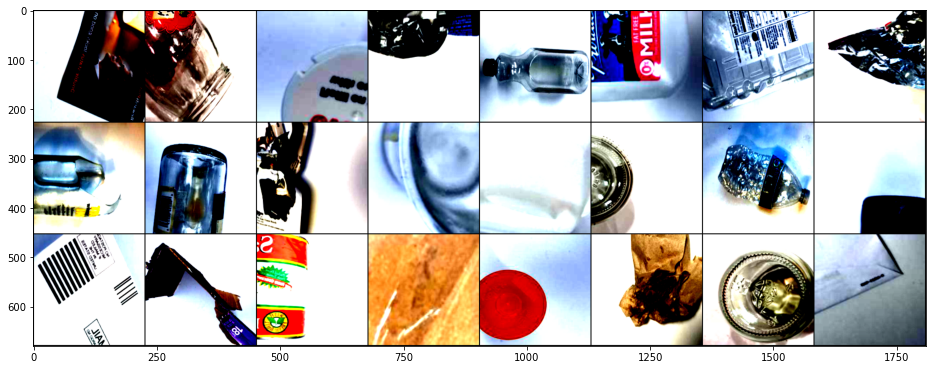

In [11]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [12]:

def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [13]:
def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
    
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
    
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
    
          if i % 20 == 19:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 20))
              running_loss = 0.0
      
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    
  

In [14]:
vgg16_backbone = models.vgg16(pretrained=True)

for param in vgg16_backbone.parameters():
      param.requires_grad = False
#num_ftrs = vgg16_backbone.fc.in_features
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16, self).__init__()
    self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

    self.drop1 = nn.Dropout(0.3)
    self.drop2 = nn.Dropout(0.2)

    self.fc1 = nn.Linear(512*7*7,512)
    self.fc2 = nn.Linear(512,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,6)


  def forward(self,x):
    
    x = self.features(x)

    x = x.view(x.shape[0],512*7*7)
    
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2(x))
    x = self.drop1(x)
    x = F.relu(self.fc3(x))
    x = self.drop1(x)
    x = F.relu(self.fc4(x))


    return x       

vgg_model = VGG16()
vgg_model = vgg_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
print(vgg_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [15]:
#epoch = 20
#vgg_model = train(vgg_model,criterion,optimizer,epoch)

In [16]:
#Fine Tuning
optimizer_ft = optim.SGD(vgg_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.5)

model_fine_tuned = train(vgg_model, criterion, optimizer_ft,exp_lr_scheduler, 
                             num_epochs=35)

Epoch: 1
[1,    20] loss: 1.791
[1,    40] loss: 1.707
[1,    60] loss: 1.458


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 1 LR: [0.01]
EPOCH OVER
############################
Training Accuracy: 55.26863806747188 Testing Accuracy 59.523809523809526
############################

Epoch: 2
[2,    20] loss: 1.058
[2,    40] loss: 1.022
[2,    60] loss: 0.997
Epoch: 2 LR: [0.01]
EPOCH OVER
############################
Training Accuracy: 64.09829237817576 Testing Accuracy 65.87301587301587
############################

Epoch: 3
[3,    20] loss: 0.882
[3,    40] loss: 0.817
[3,    60] loss: 0.817
Epoch: 3 LR: [0.01]
EPOCH OVER
############################
Training Accuracy: 71.55351936693044 Testing Accuracy 70.63492063492063
############################

Epoch: 4
[4,    20] loss: 0.768
[4,    40] loss: 0.743
[4,    60] loss: 0.794
Epoch: 4 LR: [0.01]
EPOCH OVER
############################
Training Accuracy: 65.05622657226155 Testing Accuracy 61.904761904761905
############################

Epoch: 5
[5,    20] loss: 1.142
[5,    40] loss: 0.903
[5,    60] loss: 0.769
Epoch: 5 LR: [0.01]
EPOCH OVER
#######